# Installation and Custom Functions

In [ ]:
!pip install pydicom
!pip install git+https://github.com/JoHof/lungmask
import numpy as np 
import os
import pydicom
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from lungmask import mask
import SimpleITK as sitk
from datetime import datetime 
import pytz
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 1.9MB 1.9MB/s 
  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-g0eimtzl
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-g0eimtzl
     |████████████████████████████████| 44.9MB 70kB/s 
     |████████████████████████████████| 1.0MB 35.5MB/s 
     |████████████████████████████████| 3.0MB 20.1MB/s 
  Created wheel for lungmask: filename=lungmask-0.2.8-cp36-none-any.whl size=17169 sha256=822822083f0211c0b1264cc2e4afd6c83bb385d67d8a6d90d8023ad05e11425a
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8mkxytv/wheels/59/2e/c0/1365551c1853d11aef03baf7ed94cdac831342c7f8a03e45ca
Successfully built lungmask
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
covid_path = '/content/drive/My Drive/covid/'
normal_path = '/content/drive/My Drive/normal/'
covid_masked_path = '/content/drive/My Drive/data_do_not_delete/dataset/covid/'
normal_masked_path = '/content/drive/My Drive/data_do_not_delete/dataset/normal/'
masking_log_file_start_path = '/content/drive/My Drive/data_do_not_delete/logs/mask_log/masking_'


def display_sample_stack(stack, rows=8, cols=8, start_with=0, show_every=1, cmap='gray', size=12):
  """Plots the given np.ndarray as rows x cols stack of images"""
  fig,ax = plt.subplots(rows,cols,figsize=[size, size])
  for i in range(rows*cols):
      ind = start_with + i*show_every
      ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
      ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap=cmap)
      ax[int(i/rows),int(i % rows)].axis('off')
  plt.show()


def get_time_stamp():
  """Returns current time as time stamp in IST"""
  IST = pytz.timezone('Asia/Kolkata') 
  return datetime.now(IST).strftime("%d-%m-%Y-%H:%M:%S")


def log_and_print(file, content):
  """Prints to log file and console"""
  file.write("\n" + get_time_stamp() + "\t" + content)
  print(get_time_stamp(), content)


def check_scans(start, end):
  """Returns the CT scan of Patients with ID"""
  op = []
  for id in range(start, end+1):
    try:
      curr = get_patient_DCM_folder(id)
      filepath = os.listdir(curr)[0]
      dcmfile = pydicom.dcmread(curr + '/' + filepath)
      ctscan = dcmfile[(0x0040, 0x0275)][0][(0x0040, 0x0009)].value[:9]
      op.append([id, ctscan])
    except:
      pass
  return op


def get_patient_DCM_folder(id):
  """Returns path to the Patient's DCM folder"""
  return covid_path + 'patient-%02d/'%(id)


def get_non_patient_DCM_folder(id):
  """Returns path to Non patient's DCM folder"""
  return normal_path + 'npatient-%02d/'%(id)


def load_scan(path):
  """Load all DICOM files in the path and return as array of slices"""
  slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
  slices.sort(key = lambda x: int(x.InstanceNumber))
  try:
      slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
  except:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
  for s in slices:
      s.SliceThickness = slice_thickness
  return slices


def get_pixels_hu(scans):
  '''Convert raw voxel values to HU and return image as numpy array'''
  image = np.stack([s.pixel_array for s in scans])
  # Convert to int16 (from sometimes int16), 
  # should be possible as values should always be low enough (<32k)
  image = image.astype(np.int16)
  # Set outside-of-scan pixels to 1
  # The intercept is usually -1024, so air is approximately 0
  image[image == -2000] = 0
  # Convert to Hounsfield units (HU)
  intercept = scans[0].RescaleIntercept
  slope = scans[0].RescaleSlope
  if slope != 1:
      image = slope * image.astype(np.float64)
      image = image.astype(np.int16)
  image += np.int16(intercept)
  return np.array(image, dtype=np.int16)


def read_dicom_file(filepath):
  """Read and load volume"""
  img = load_scan(filepath)
  scan = get_pixels_hu(img)
  return scan


def resize_volume(img):
  """Resize across z-axis"""
  # Set the desired depth
  desired_depth = 64
  desired_width = 128
  desired_height = 128

  # Get current depth
  current_depth = img.shape[0]
  current_width = img.shape[1]
  current_height = img.shape[-1]

  # Compute depth factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height

  # Resize across z-axis
  img = ndimage.zoom(img, (depth_factor, width_factor, height_factor), order=1)
  return img


def process_scan(path):
  """Read and resize volume"""
  # Read scan
  print('About to read DICOM at', path)
  volume = read_dicom_file(path)
  print('CT Scan read successful from', path)
  print(type(volume), volume.shape)

  # Resize width, height and depth
  volume = resize_volume(volume)
  print('Resizing successful')
  print(volume.shape)
  plt.imshow(volume[30], cmap="gray")
  return volume


def apply_mask(img):
  """Returns original sampled images and segmented images after masking"""
  # The original resized image
  orig = sitk.GetImageFromArray(img, isVector=False)
  # Apply Mask
  seg = mask.apply(orig)
  return img, np.multiply(img, seg)


def segmentation(patient_id_from, patient_id_to=None, covid=True):
  """Perform segmentation for patients in the given range of IDs"""
  patient_id_to = patient_id_from if patient_id_to is None else patient_id_to
  mask_log = masking_log_file_start_path + get_time_stamp() + '.txt'
  log = open(mask_log, "a")

  for patient_id in range(patient_id_from, patient_id_to + 1):
    log_and_print(log, ("" if covid else "Non ") + "Patient ID = " + str(patient_id))
    # Segmentation and mask
    path = get_patient_DCM_folder(patient_id) if covid else get_non_patient_DCM_folder(patient_id)
    img = process_scan(path)
    orig_np, seg_np = apply_mask(img)
    # Save
    save_path = (covid_masked_path if covid else (normal_masked_path + "n")) + "masked_%02d.npy" % (patient_id)
    log_and_print(log, "Saving file at = " + save_path)
    np.save(save_path, seg_np)
    log_and_print(log, "Segmentation and saving successful for " + ("" if covid else "Non ") + "Patient " + str(patient_id) + "\n\n")

  # After Segmentation of last patient
  display_sample_stack(np.load((covid_masked_path if covid else (normal_masked_path + "n")) + "masked_%02d.npy"%(patient_id_to)))
  log.close()


def get_images(path):
  """Load image from .npy file in the given path"""
  location = '/content/drive/My Drive/data_do_not_delete/dataset/' + path
  print(get_time_stamp())
  print('Loading', location)
  img = np.load(location)
  print(img.shape)
  return np.array(img)


def store_many_hdf5(h5file, images, labels, scores):
  """Stores the images, labels, scores as dataset"""
  num_images = len(images)
  # Create a dataset in the file
  dataset = h5file.create_dataset(
      "images", np.shape(images), h5py.h5t.STD_I32BE, data=images
  )
  meta_set = h5file.create_dataset(
      "labels", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
  )
  scores_set = h5file.create_dataset(
      "scores", np.shape(scores), h5py.h5t.STD_U8BE, data=scores
  )


def read_many_hdf5(h5file):
  """Loads dataset from given h5file"""
  images = np.array(h5file["images"]).astype("int32")
  labels = np.array(h5file["labels"]).astype("uint8")
  scores = np.array(h5file["scores"]).astype("uint8")
  return images, labels, scores


# Segmentation (Do not execute again)

08-11-2020-12:24:53 Patient ID = 116
About to read DICOM at /content/drive/My Drive/covid/patient-116/
CT Scan read successful from /content/drive/My Drive/covid/patient-116/
<class 'numpy.ndarray'> (635, 512, 512)
Resizing successful
(64, 128, 128)


Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_r231-d5d2fc3d.pth" to /root/.cache/torch/hub/checkpoints/unet_r231-d5d2fc3d.pth


100%|██████████| 35/35 [00:00<00:00, 165.34it/s]


08-11-2020-12:32:49 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_116.npy
08-11-2020-12:32:50 Segmentation and saving successful for Patient 116


08-11-2020-12:32:50 Patient ID = 117
About to read DICOM at /content/drive/My Drive/covid/patient-117/
CT Scan read successful from /content/drive/My Drive/covid/patient-117/
<class 'numpy.ndarray'> (601, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 25/25 [00:00<00:00, 160.99it/s]


08-11-2020-12:39:26 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_117.npy
08-11-2020-12:39:26 Segmentation and saving successful for Patient 117


08-11-2020-12:39:26 Patient ID = 118
About to read DICOM at /content/drive/My Drive/covid/patient-118/
CT Scan read successful from /content/drive/My Drive/covid/patient-118/
<class 'numpy.ndarray'> (512, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 8/8 [00:00<00:00, 149.33it/s]


08-11-2020-12:45:45 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_118.npy
08-11-2020-12:45:45 Segmentation and saving successful for Patient 118


08-11-2020-12:45:45 Patient ID = 119
About to read DICOM at /content/drive/My Drive/covid/patient-119/
CT Scan read successful from /content/drive/My Drive/covid/patient-119/
<class 'numpy.ndarray'> (575, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 16/16 [00:00<00:00, 157.38it/s]


08-11-2020-12:52:38 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_119.npy
08-11-2020-12:52:38 Segmentation and saving successful for Patient 119


08-11-2020-12:52:38 Patient ID = 120
About to read DICOM at /content/drive/My Drive/covid/patient-120/
CT Scan read successful from /content/drive/My Drive/covid/patient-120/
<class 'numpy.ndarray'> (538, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 18/18 [00:00<00:00, 139.24it/s]


08-11-2020-12:58:47 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_120.npy
08-11-2020-12:58:47 Segmentation and saving successful for Patient 120


08-11-2020-12:58:47 Patient ID = 121
About to read DICOM at /content/drive/My Drive/covid/patient-121/
CT Scan read successful from /content/drive/My Drive/covid/patient-121/
<class 'numpy.ndarray'> (558, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 23/23 [00:00<00:00, 149.49it/s]


08-11-2020-13:05:12 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_121.npy
08-11-2020-13:05:12 Segmentation and saving successful for Patient 121


08-11-2020-13:05:12 Patient ID = 122
About to read DICOM at /content/drive/My Drive/covid/patient-122/
CT Scan read successful from /content/drive/My Drive/covid/patient-122/
<class 'numpy.ndarray'> (568, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 16/16 [00:00<00:00, 138.12it/s]


08-11-2020-13:11:31 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_122.npy
08-11-2020-13:11:31 Segmentation and saving successful for Patient 122


08-11-2020-13:11:31 Patient ID = 123
About to read DICOM at /content/drive/My Drive/covid/patient-123/
CT Scan read successful from /content/drive/My Drive/covid/patient-123/
<class 'numpy.ndarray'> (640, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 29/29 [00:00<00:00, 143.64it/s]


08-11-2020-13:18:52 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_123.npy
08-11-2020-13:18:52 Segmentation and saving successful for Patient 123


08-11-2020-13:18:52 Patient ID = 124
About to read DICOM at /content/drive/My Drive/covid/patient-124/
CT Scan read successful from /content/drive/My Drive/covid/patient-124/
<class 'numpy.ndarray'> (520, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 32/32 [00:00<00:00, 138.72it/s]


08-11-2020-13:25:03 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_124.npy
08-11-2020-13:25:04 Segmentation and saving successful for Patient 124


08-11-2020-13:25:04 Patient ID = 125
About to read DICOM at /content/drive/My Drive/covid/patient-125/
CT Scan read successful from /content/drive/My Drive/covid/patient-125/
<class 'numpy.ndarray'> (553, 512, 512)
Resizing successful
(64, 128, 128)


100%|██████████| 17/17 [00:00<00:00, 133.52it/s]


08-11-2020-13:31:15 Saving file at = /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_125.npy
08-11-2020-13:31:15 Segmentation and saving successful for Patient 125




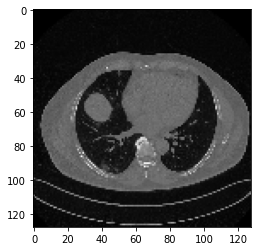

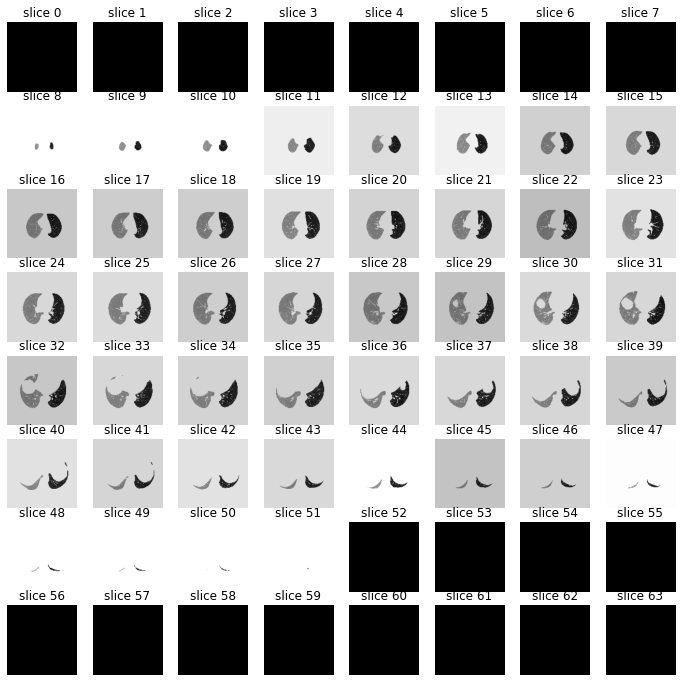

In [ ]:
# segmentation(1, 125, covid=True)

In [ ]:
# segmentation(1, 85, covid=False)

# Dataset Preprocessing

In [ ]:
df = pd.read_csv('/content/drive/My Drive/data_do_not_delete/data.csv')
temp_x = df['path'].values
temp_y = df['covid'].values
temp_scores = df['score'].values

In [ ]:
# Split data 210 => 170 (train) + 40 (test)
split = 170
x_train = np.array([get_images(path) for path in temp_x[:split]])
y_train = np.array(temp_y[:split])
scores_train = np.array(temp_scores[:split])

08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_58.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_16.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_27.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_02.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_33.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_54.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_81.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_105.npy
(64, 128, 128)
08-11-2020-23:33:53
Loading /content/drive/My Drive/data_do_not_delete/data

In [ ]:
print(x_train.shape, y_train.shape, scores_train.shape)

(170, 64, 128, 128) (170,) (170,)


In [ ]:
# split = 170
x_val = np.array([get_images(path) for path in temp_x[split:]])
y_val = np.array(temp_y[split:])
scores_val = np.array(temp_scores[split:])

08-11-2020-23:37:13
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_99.npy
(64, 128, 128)
08-11-2020-23:37:14
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_85.npy
(64, 128, 128)
08-11-2020-23:37:15
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_122.npy
(64, 128, 128)
08-11-2020-23:37:16
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_118.npy
(64, 128, 128)
08-11-2020-23:37:17
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_22.npy
(64, 128, 128)
08-11-2020-23:37:18
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_50.npy
(64, 128, 128)
08-11-2020-23:37:19
Loading /content/drive/My Drive/data_do_not_delete/dataset/normal/nmasked_17.npy
(64, 128, 128)
08-11-2020-23:37:20
Loading /content/drive/My Drive/data_do_not_delete/dataset/covid/masked_72.npy
(64, 128, 128)
08-11-2020-23:37:21
Loading /content/drive/My Drive/data_do_not_delete/dataset/norma

In [ ]:
print(x_val.shape, y_val.shape, scores_val.shape)

(40, 64, 128, 128) (40,) (40,)


In [ ]:
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 170 and 40.


In [ ]:
x_train = x_train.reshape(len(x_train), 64, 128, 128, 1)
x_val = x_val.reshape(len(x_val), 64, 128, 128, 1)
y_train = y_train.reshape(len(y_train), 1)
y_val = y_val.reshape(len(y_val), 1)
scores_train = scores_train.reshape(len(scores_train), 1)
scores_val = scores_val.reshape(len(scores_val), 1)
print(x_train.shape, y_train.shape, scores_train.shape)
print(x_val.shape, y_val.shape, scores_val.shape)

(170, 64, 128, 128, 1) (170, 1) (170, 1)
(40, 64, 128, 128, 1) (40, 1) (40, 1)


In [ ]:
# train = h5py.File('/content/drive/My Drive/data_do_not_delete/dataset/training.h5', 'w')
# store_many_hdf5(train, x_train, y_train, scores_train)
# train.close()

In [ ]:
# vali = h5py.File('/content/drive/My Drive/data_do_not_delete/dataset/validation.h5', 'w')
# store_many_hdf5(vali, x_val, y_val, scores_val)
# vali.close()

# Load Dataset

In [ ]:
train = h5py.File('/content/drive/My Drive/data_do_not_delete/dataset/training.h5', 'r')
x_train, y_train, scores_train = read_many_hdf5(train)
train.close()

In [ ]:
print(x_train.shape, y_train.shape, scores_train.shape)

(170, 64, 128, 128, 1) (170, 1) (170, 1)


In [ ]:
vali = h5py.File('/content/drive/My Drive/data_do_not_delete/dataset/validation.h5', 'r')
x_val, y_val, scores_val = read_many_hdf5(vali)
vali.close()

In [ ]:
print(x_val.shape, y_val.shape, scores_val.shape)

(40, 64, 128, 128, 1) (40, 1) (40, 1)


# Classification

## Choose Input and Output

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [ ]:
batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (64, 128, 128, 1)


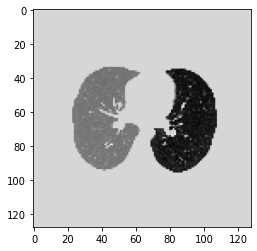

In [ ]:
# Visualizing one slice
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[30, :, :]), cmap="gray")

## Model 1 - 3D CNN 

In [ ]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, width, height, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [ ]:
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 62, 126, 126, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 63, 63, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 63, 63, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 29, 61, 61, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 30, 30, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 30, 30, 64)    256   

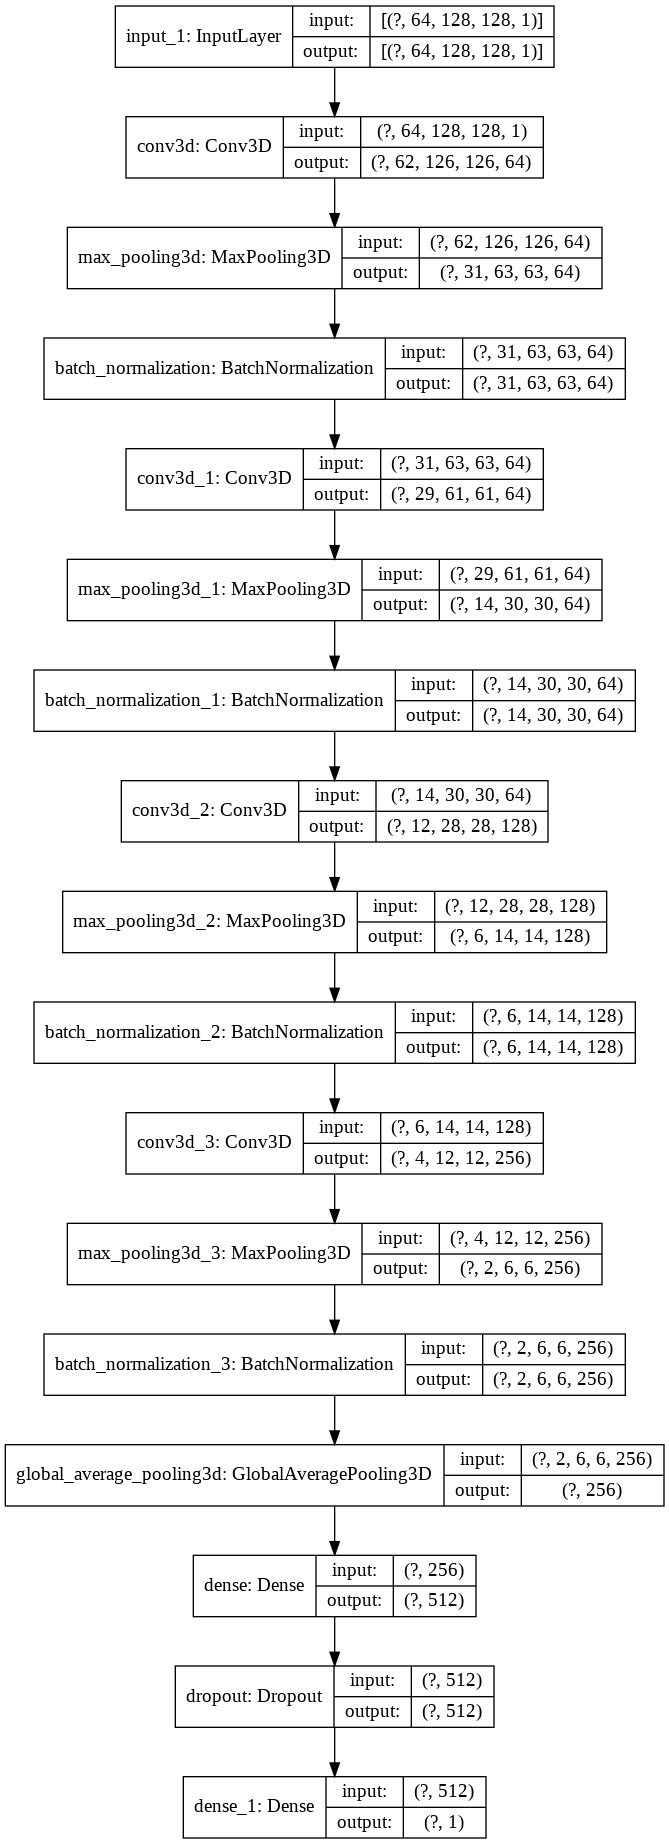

In [ ]:
dot_img_file = 'model_basic.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## 3D CNN - Training and Validation

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [ ]:
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
85/85 - 14s - loss: 0.6710 - acc: 0.6412 - val_loss: 0.7463 - val_acc: 0.4500
Epoch 2/100
85/85 - 13s - loss: 0.6645 - acc: 0.5235 - val_loss: 0.5841 - val_acc: 0.6750
Epoch 3/100
85/85 - 14s - loss: 0.6432 - acc: 0.6059 - val_loss: 0.5154 - val_acc: 0.8000
Epoch 4/100
85/85 - 14s - loss: 0.6120 - acc: 0.6353 - val_loss: 0.6157 - val_acc: 0.5750
Epoch 5/100
85/85 - 14s - loss: 0.6057 - acc: 0.6882 - val_loss: 0.5143 - val_acc: 0.6250
Epoch 6/100
85/85 - 13s - loss: 0.5803 - acc: 0.6941 - val_loss: 0.8270 - val_acc: 0.6000
Epoch 7/100
85/85 - 14s - loss: 0.5641 - acc: 0.7059 - val_loss: 0.5046 - val_acc: 0.7250
Epoch 8/100
85/85 - 13s - loss: 0.5676 - acc: 0.7118 - val_loss: 0.7727 - val_acc: 0.5250
Epoch 9/100
85/85 - 14s - loss: 0.5312 - acc: 0.7235 - val_loss: 0.6290 - val_acc: 0.6250
Epoch 10/100
85/85 - 14s - loss: 0.5558 - acc: 0.6882 - val_loss: 0.4977 - val_acc: 0.6750
Epoch 11/100
85/85 - 14s - loss: 0.5195 - acc: 0.7412 - val_loss: 0.4738 - val_acc: 0.7500
Epoch 12

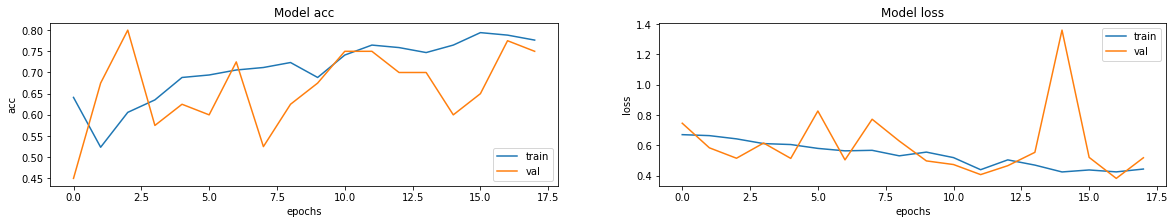

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
results = model.evaluate(x_val, y_val, batch_size=10)

4/4 [==============================] - 1s 190ms/step - loss: 0.3824 - acc: 0.7750


In [ ]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 4.28 percent confident that CT scan is normal
This model is 95.72 percent confident that CT scan is abnormal


In [ ]:
y_val[0][0]

1

# Scoring

## Choose Input and Output

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, scores_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, scores_val))

In [ ]:
batch_size = 2

train_dataset = (
    train_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (64, 128, 128, 1)


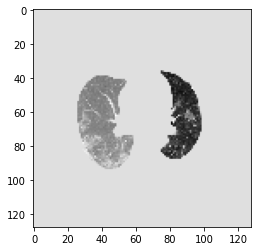

In [ ]:
# Visualizing one slice
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[30, :, :]), cmap="gray")

## Model 3 - 3D CNN for Scoring (with Linear Activation)

In [ ]:
def get_scoring_model(width=128, height=128, depth=64, final_activation="linear"):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((depth, width, height, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation=final_activation)(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

In [ ]:
scoring_model_linear = get_scoring_model(width=128, height=128, depth=64, final_activation="linear")
scoring_model_linear.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 62, 126, 126, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 63, 63, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 63, 63, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 29, 61, 61, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 30, 30, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 30, 30, 64)    256   

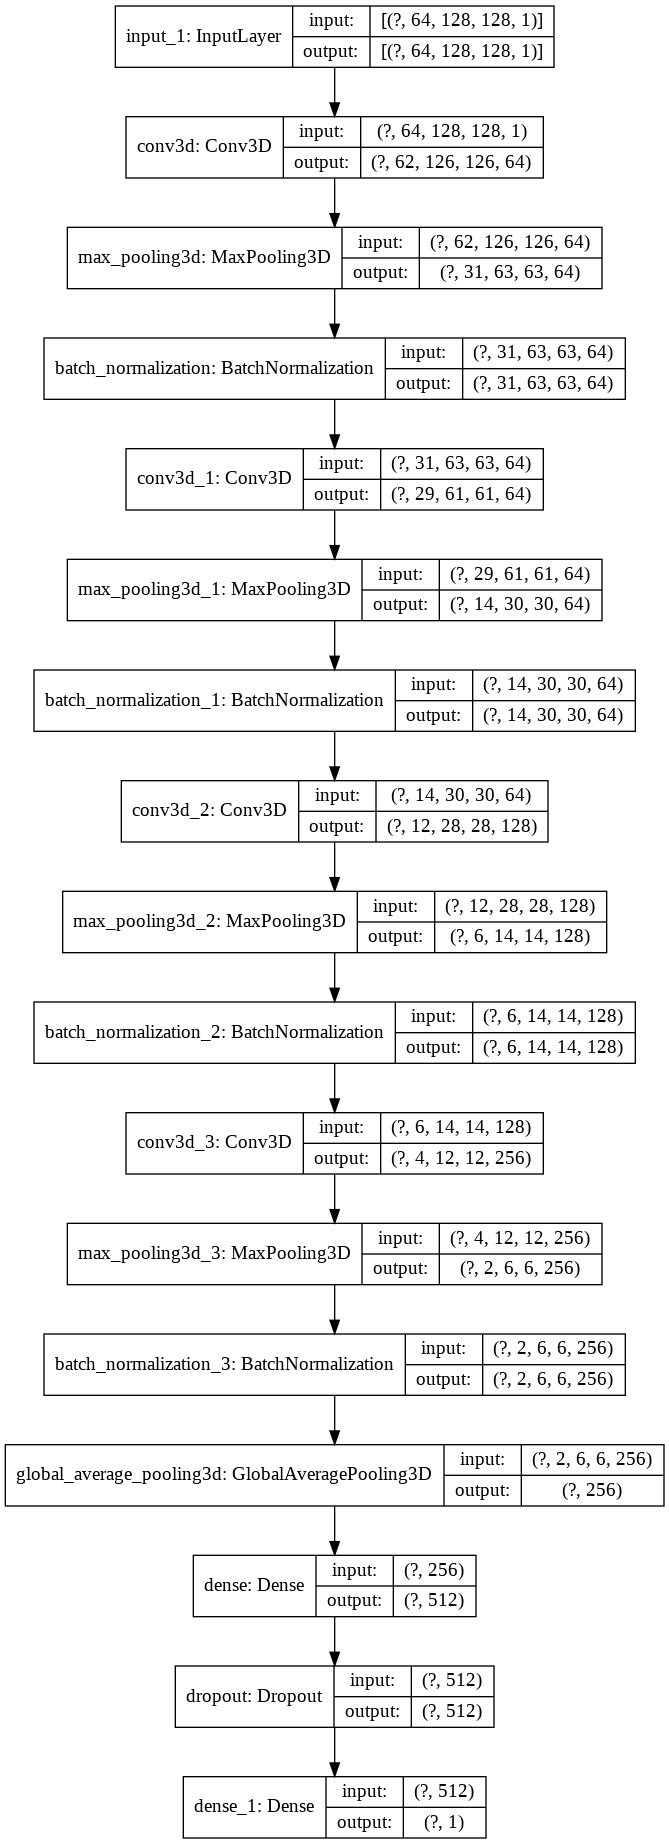

In [ ]:
scoring_model_img_linear = '/content/drive/My Drive/data_do_not_delete/dataset/scoring_model_linear.png'
tf.keras.utils.plot_model(scoring_model_linear, to_file=scoring_model_img_linear, show_shapes=True)

## 3D CNN Linear - Training and Validation

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
scoring_model_linear.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mse"],
)

# Define callbacks.
checkpoint_cb_scoring_linear = keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/data_do_not_delete/dataset/scoring_linear_3d.h5", save_best_only=True
)
early_stopping_cb_scoring_linear = keras.callbacks.EarlyStopping(monitor="val_mse", patience=15)

In [ ]:
# Train the model, doing validation at the end of each epoch
epochs = 100
scoring_model_linear.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb_scoring_linear, early_stopping_cb_scoring_linear],
)

Epoch 1/100
85/85 - 20s - loss: 913.5384 - mse: 913.5384 - val_loss: 994.6662 - val_mse: 994.6662
Epoch 2/100
85/85 - 20s - loss: 655.0367 - mse: 655.0367 - val_loss: 350.4662 - val_mse: 350.4662
Epoch 3/100
85/85 - 19s - loss: 505.2814 - mse: 505.2814 - val_loss: 497.1805 - val_mse: 497.1805
Epoch 4/100
85/85 - 19s - loss: 459.2404 - mse: 459.2404 - val_loss: 353.0202 - val_mse: 353.0202
Epoch 5/100
85/85 - 19s - loss: 349.4583 - mse: 349.4583 - val_loss: 563.1483 - val_mse: 563.1483
Epoch 6/100
85/85 - 19s - loss: 373.1845 - mse: 373.1845 - val_loss: 515.8281 - val_mse: 515.8281
Epoch 7/100
85/85 - 19s - loss: 357.4106 - mse: 357.4106 - val_loss: 455.1203 - val_mse: 455.1203
Epoch 8/100
85/85 - 19s - loss: 330.5908 - mse: 330.5908 - val_loss: 510.1369 - val_mse: 510.1369
Epoch 9/100
85/85 - 19s - loss: 299.9180 - mse: 299.9180 - val_loss: 1621.2931 - val_mse: 1621.2931
Epoch 10/100
85/85 - 19s - loss: 383.1299 - mse: 383.1299 - val_loss: 368.1598 - val_mse: 368.1598
Epoch 11/100
85/8

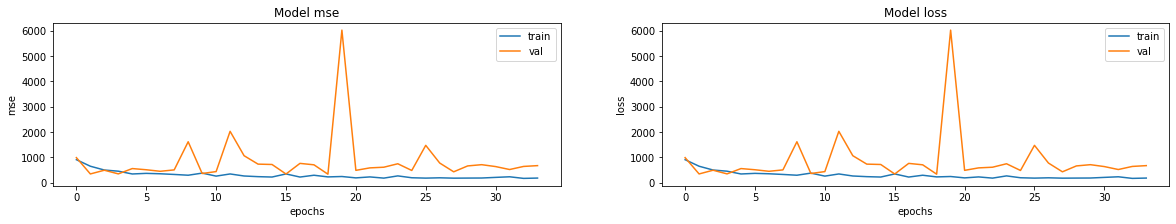

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["mse", "loss"]):
    ax[i].plot(scoring_model_linear.history.history[metric])
    ax[i].plot(scoring_model_linear.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
results_scoring_linear = scoring_model_linear.evaluate(x_val, scores_val, batch_size=5)

8/8 [==============================] - 1s 158ms/step - loss: 678.7335 - mse: 678.7335


In [ ]:
scoring_model_linear.load_weights("/content/drive/My Drive/data_do_not_delete/dataset/scoring_linear_3d.h5")
prediction = scoring_model_linear.predict(np.expand_dims(x_val[0], axis=0))[0]
print("Affected Score Percentage =", prediction[0], "%")
print("Predicted CTSI = ", prediction[0]//4)

Affected Score Percentage = 43.03343 %
Predicted CTSI =  10.0


In [ ]:
print("Actual Score Percentage =", scores_val[0][0], "%")
print("Actual CTSI = ", scores_val[0][0]//4)

Actual Score Percentage = 52 %
Actual CTSI =  13


In [ ]:
def get_severity_class(score):
  """Returns severity for the given score"""
  if 0 <= score < 20:
    return 'Low'
  if 20 <= score < 40:
    return 'Mild'
  if 40 <= score < 60:
    return 'Moderate'
  if 60 <= score < 80:
    return 'Severe'
  if score >= 80:
    return 'Critical'

In [ ]:
pred_score = scoring_model_linear.predict(x_val, batch_size=5)

pred_class = np.reshape(np.array([get_severity_class(score) for score in pred_score]), (len(pred_score), 1))
actual_class = np.reshape(np.array([get_severity_class(score) for score in scores_val]), (len(pred_score), 1))

In [ ]:
array = np.concatenate((pred_class, actual_class), axis = 1)
data_frame = pd.DataFrame(data = array,  
                  columns = ['Predicted Severity', 'Actual Severity'])
print(data_frame) 

   Predicted Severity Actual Severity
0            Moderate        Moderate
1                 Low            Mild
2                 Low            Mild
3                 Low            Mild
4            Moderate          Severe
5                 Low             Low
6                 Low             Low
7            Moderate          Severe
8                 Low             Low
9                 Low            Mild
10             Severe          Severe
11           Moderate            Mild
12                Low             Low
13               Mild            Mild
14                Low             Low
15           Moderate        Moderate
16                Low             Low
17                Low             Low
18                Low             Low
19               Mild        Moderate
20               Mild        Moderate
21                Low             Low
22                Low             Low
23                Low             Low
24                Low             Low
25          

## Model 4 - 3D CNN for Scoring (with ReLu)

In [ ]:
scoring_model_relu = get_scoring_model(width=128, height=128, depth=64, final_activation="relu")
scoring_model_relu.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 62, 126, 126, 64)  1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 31, 63, 63, 64)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 63, 63, 64)    256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 29, 61, 61, 64)    110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 14, 30, 30, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 30, 30, 64)    256   

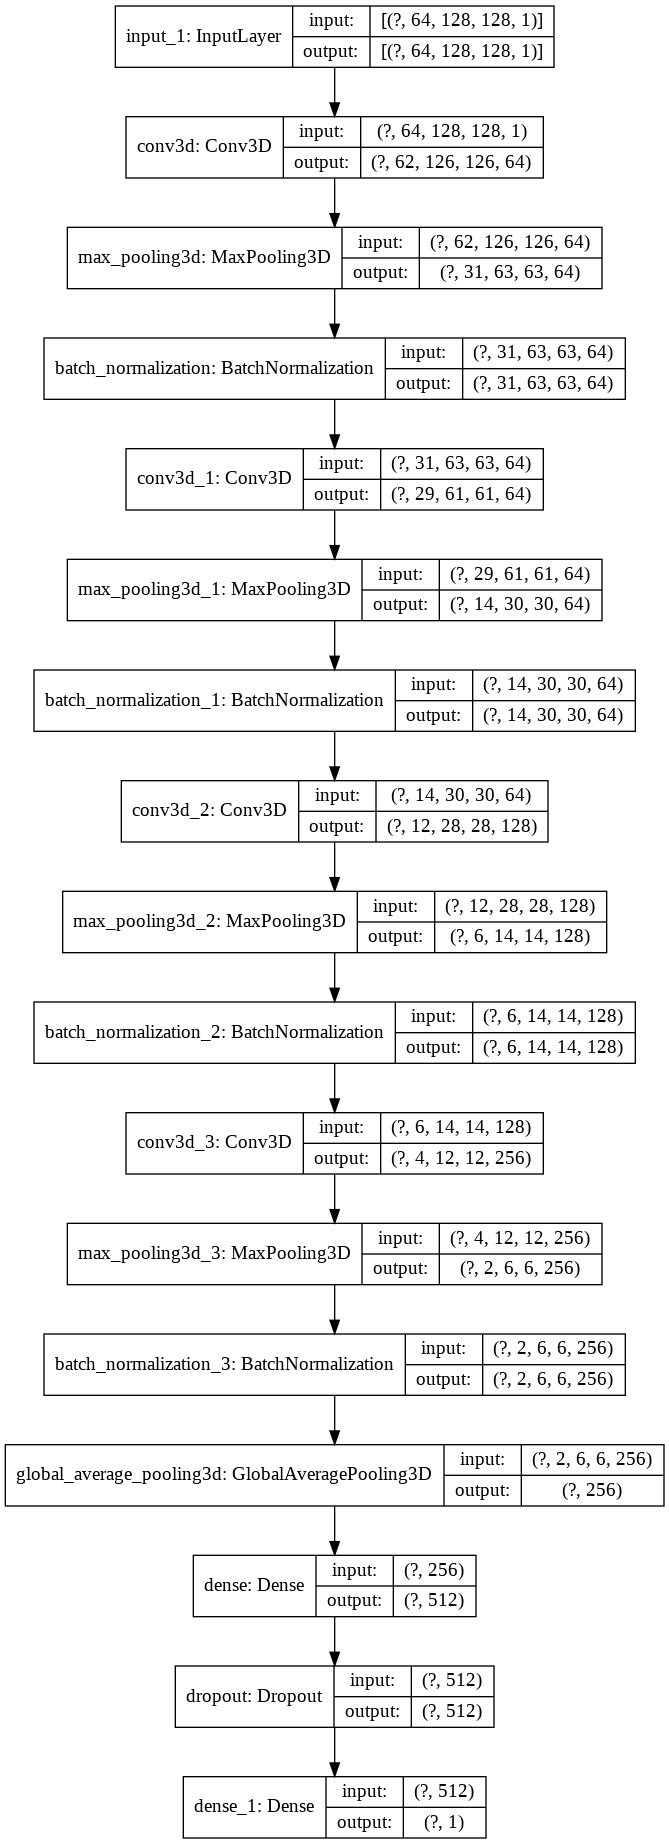

In [ ]:
scoring_model_img_relu = '/content/drive/My Drive/data_do_not_delete/dataset/scoring_model_relu.png'
tf.keras.utils.plot_model(scoring_model_relu, to_file=scoring_model_img_relu, show_shapes=True)

## 3D CNN ReLU - Training and Validation

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
scoring_model_relu.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["mse", "acc"],
)

# Define callbacks.
checkpoint_cb_scoring_relu = keras.callbacks.ModelCheckpoint(
    "/content/drive/My Drive/data_do_not_delete/dataset/scoring_relu_3d.h5", save_best_only=True
)
early_stopping_cb_scoring_relu = keras.callbacks.EarlyStopping(monitor="val_mse", patience=15)

In [ ]:
# Train the model, doing validation at the end of each epoch
epochs = 100
scoring_model_relu.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb_scoring_relu, early_stopping_cb_scoring_relu],
)

Epoch 1/100
85/85 - 34s - loss: 954.6846 - mse: 954.6846 - acc: 0.2412 - val_loss: 949.1820 - val_mse: 949.1820 - val_acc: 0.0250
Epoch 2/100
85/85 - 34s - loss: 935.0905 - mse: 935.0905 - acc: 0.1588 - val_loss: 1049.1855 - val_mse: 1049.1855 - val_acc: 0.0750
Epoch 3/100
85/85 - 34s - loss: 897.6775 - mse: 897.6775 - acc: 0.1706 - val_loss: 1071.4114 - val_mse: 1071.4114 - val_acc: 0.0750
Epoch 4/100
85/85 - 34s - loss: 898.0474 - mse: 898.0474 - acc: 0.1529 - val_loss: 1033.6292 - val_mse: 1033.6292 - val_acc: 0.0750
Epoch 5/100
85/85 - 34s - loss: 880.3712 - mse: 880.3712 - acc: 0.1529 - val_loss: 1127.1357 - val_mse: 1127.1357 - val_acc: 0.1750
Epoch 6/100
85/85 - 34s - loss: 896.5170 - mse: 896.5170 - acc: 0.1588 - val_loss: 1702.5834 - val_mse: 1702.5834 - val_acc: 0.0250
Epoch 7/100
85/85 - 35s - loss: 873.0046 - mse: 873.0046 - acc: 0.1765 - val_loss: 584.7206 - val_mse: 584.7206 - val_acc: 0.1000
Epoch 8/100
85/85 - 34s - loss: 669.6417 - mse: 669.6417 - acc: 0.2471 - val_los

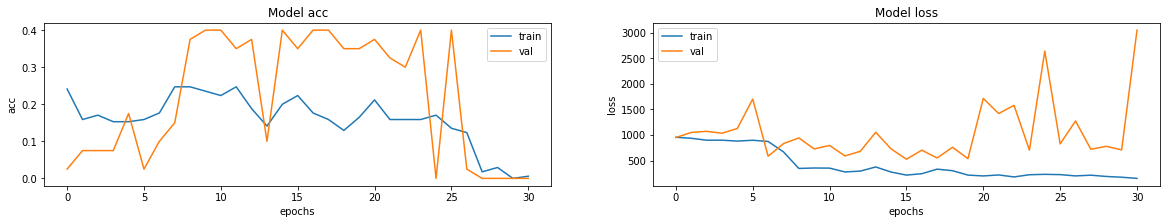

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(scoring_model_relu.history.history[metric])
    ax[i].plot(scoring_model_relu.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
results_scoring_relu = scoring_model_relu.evaluate(x_val, scores_val, batch_size=5)

8/8 [==============================] - 2s 272ms/step - loss: 3051.2068 - mse: 3051.2070 - acc: 0.0000e+00


In [ ]:
scoring_model_relu.load_weights("/content/drive/My Drive/data_do_not_delete/dataset/scoring_relu_3d.h5")
prediction = scoring_model_relu.predict(np.expand_dims(x_val[0], axis=0))[0]
print("Affected Score Percentage =", prediction[0], "%")
print("Predicted CTSI = ", prediction[0]//4)

Affected Score Percentage = 46.78831 %
Predicted CTSI =  11.0


In [ ]:
print("Actual Score Percentage =", scores_val[0][0], "%")
print("Actual CTSI = ", scores_val[0][0]//4)

Actual Score Percentage = 52 %
Actual CTSI =  13


In [ ]:
pred_score = scoring_model_relu.predict(x_val, batch_size=5)

pred_class = np.reshape(np.array([get_severity_class(score) for score in pred_score]), (len(pred_score), 1))
actual_class = np.reshape(np.array([get_severity_class(score) for score in scores_val]), (len(pred_score), 1))

In [ ]:
array = np.concatenate((pred_class, actual_class), axis = 1)
data_frame = pd.DataFrame(data = array,  
                  columns = ['Predicted Severity', 'Actual Severity'])
print(data_frame) 

   Predicted Severity Actual Severity
0            Moderate        Moderate
1                 Low            Mild
2                 Low            Mild
3                 Low            Mild
4              Severe          Severe
5                 Low             Low
6                 Low             Low
7            Moderate          Severe
8                 Low             Low
9                 Low            Mild
10             Severe          Severe
11               Mild            Mild
12                Low             Low
13                Low            Mild
14                Low             Low
15           Critical        Moderate
16                Low             Low
17                Low             Low
18                Low             Low
19                Low        Moderate
20                Low        Moderate
21                Low             Low
22                Low             Low
23                Low             Low
24                Low             Low
25          

# PDF conversion

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/3DCNN.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/3DCNN.ipynb to PDF
[NbConvertApp] Support files will be in 3DCNN_files/
[NbConvertApp] Making directory ./3DCNN_files
[NbConvertApp] Making directory ./3DCNN_files
[NbConvertApp] Making directory ./3DCNN_files
[NbConvertApp] Making directory ./3DCNN_files
[NbConvertApp] Making directory ./3DCNN_files
[NbConvertApp] Writing 139688 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 356478 bytes to /content/drive/My Drive/Colab Notebooks/3DCNN.pdf
